# Detección de Fraude en Transacciones Financiera

Grupo: Los deshauciados
- Raúl Calzado Olmo
- José Santos Salvador
- Eugenio Vargas Cabrera
- María Soledad Pérez Urbano
- Jesús Manuel Contreras Herrera

## Descripción breve del problema y del conjunto de datos
El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos. Este conjunto de datos presenta transacciones ocurridas en dos días, donde se registraron 492 fraudes de un total de 284,807 transacciones. El conjunto de datos está altamente desequilibrado: la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Solo contiene variables de entrada numéricas, que son el resultado de una transformación PCA (Análisis de Componentes Principales). Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales ni más información de contexto sobre los datos. Las características V1, V2, … V28 son los componentes principales obtenidos con PCA. Las únicas características que no han sido transformadas con PCA son 'Time' y 'Amount'. La característica 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos. La característica 'Amount' es el monto de la transacción, y esta característica puede ser utilizada para aprendizaje dependiente de costos específicos de ejemplos. La característica 'Class' es la variable de respuesta, y toma el valor 1 en caso de fraude y 0 en caso contrario.

## Carga de datos
**Fuente**: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:


pd.set_option('display.max_columns', None) # elimina el truncado
data = pd.read_csv("./data/creditcard.csv")
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

### Resumen estadistico

In [ ]:
print(data.describe())
print(data['Class'].value_counts())
print(f"Numero de datos nulos: {data.isnull().sum()}")


## Comprobar distribuciones

In [ ]:
def freedman_diaconis_bins(data, feature):
    # Calcular el rango intercuartílico (IQR)
    iqr = np.percentile(data[feature], 75) - np.percentile(data[feature], 25)
    n = len(data[feature])
    
    # Prevenir división por cero
    if iqr == 0:
        return 10  # Valor por defecto si no hay variación
    
    bin_width = 2 * iqr / np.cbrt(n)
    num_bins = int((data[feature].max() - data[feature].min()) / bin_width)
    return max(num_bins, 1)

In [2]:
# Cogemos las variables independientes
independent_variables = [f'V{i}' for i in range(1, 29)]

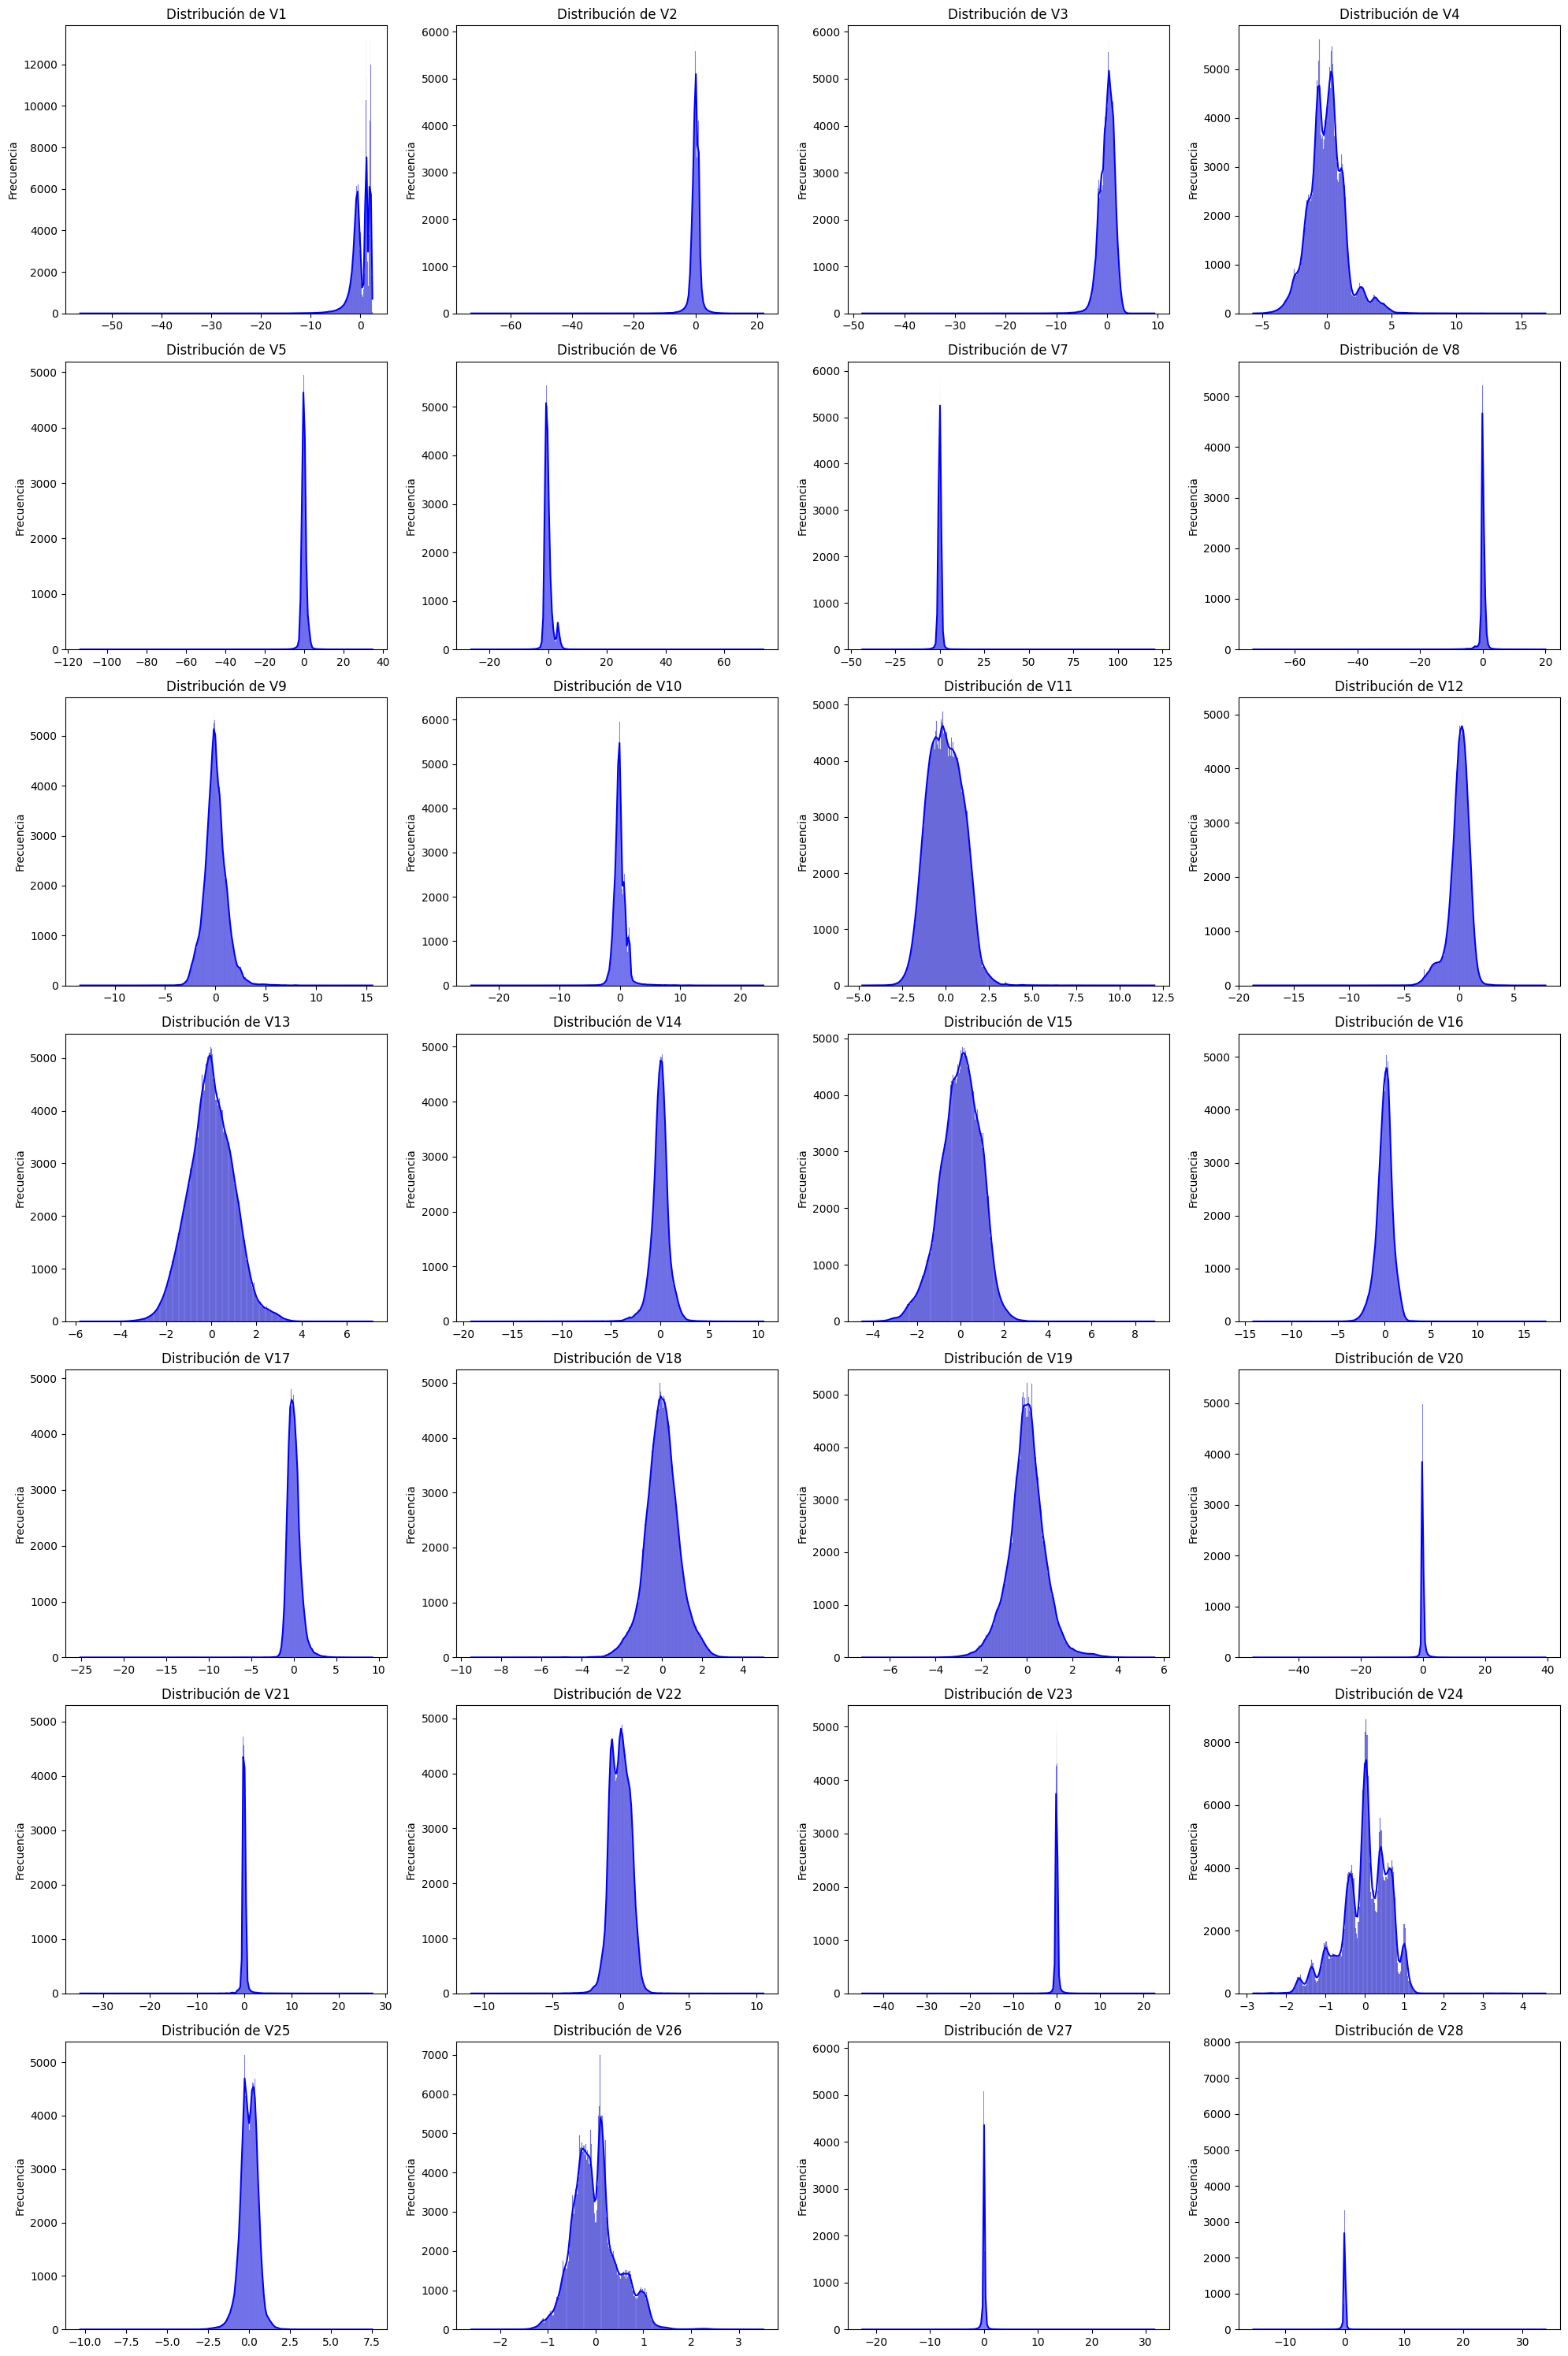

In [ ]:

plt.figure(figsize=(20, 30))

# Crear subgráficos para cada variable de V1 a V28
for idx, feature in enumerate(independent_variables, 1):
    plt.subplot(7, 4, idx)
    bins = freedman_diaconis_bins(data, feature) # calculamos los bins basandonos en el rango intercuartilico
    sns.histplot(data[feature], kde=True, bins=bins, color='blue', edgecolor='black')
    plt.title(f'Distribución de {feature}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Como podemos observar los datos de todas las variables independientes ya están normalizadas. Además, no hay datos nulos

### Correlacion de las variables

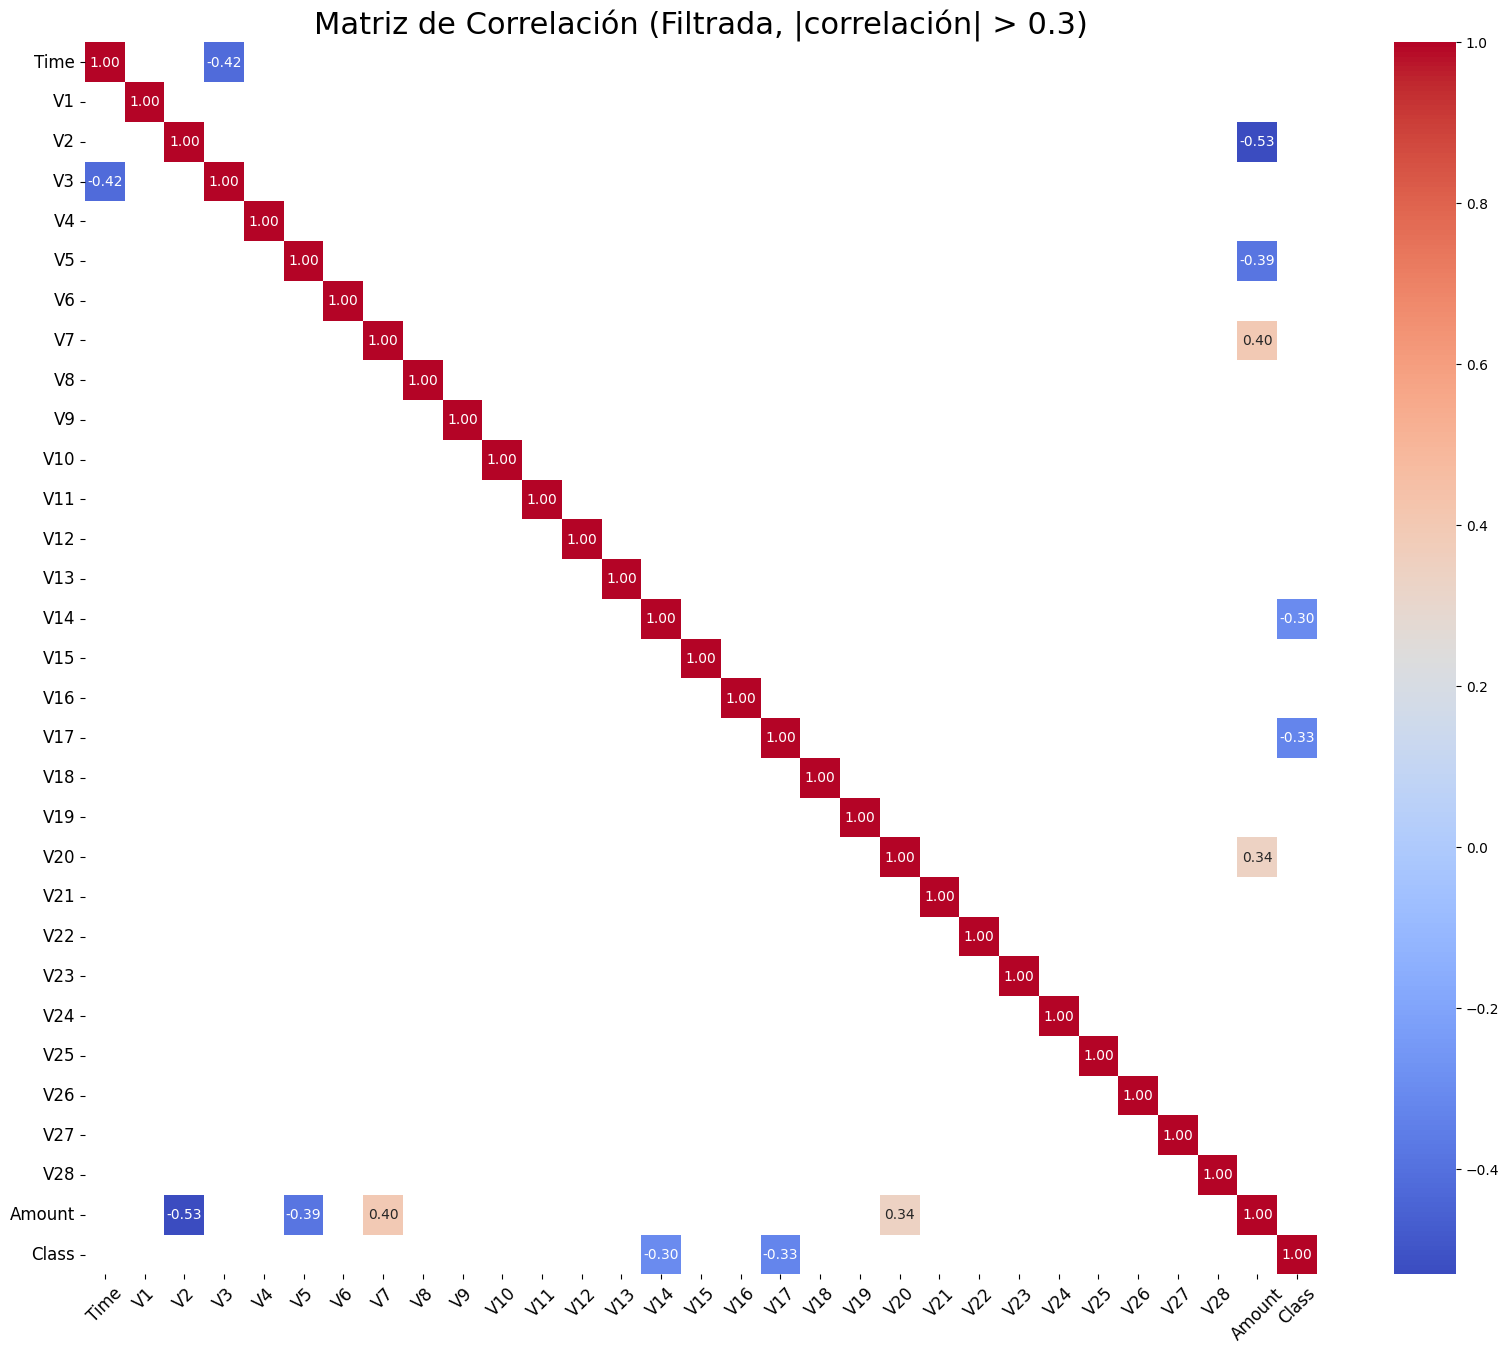

In [9]:
correlation_matrix = data.corr()
threshold = 0.3
filtered_corr = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

# Configurar el tamaño del gráfico
plt.figure(figsize=(20, 16))

sns.heatmap(filtered_corr, 
            annot=True,         # Mostrar valores numéricos
            fmt=".2f",          # Limitar a 2 decimales
            cmap="coolwarm",    # Colores del heatmap
            cbar=True,          # Mostrar barra de color
            square=True,        # Hacer celdas cuadradas
            annot_kws={"size": 10},  # Tamaño del texto en las celdas
            mask=np.isnan(filtered_corr))  # Ocultar celdas que no cumplen el umbral

# Título del heatmap
plt.title("Matriz de Correlación (Filtrada, |correlación| > 0.3)", fontsize=22)
plt.xticks(fontsize=12, rotation=45)  # Ajustar tamaño y rotación de las etiquetas del eje X
plt.yticks(fontsize=12, rotation=0) 
plt.show()

Podemos observar que hay correlaciones moderadas:
- Entre Amount y las variables [V2(-), V5(-), V7(+), V20(+)]. 
- Entre la variable dependiente Class y la variables independientes [V14(-), V17(-)]
- Entre la variable Time y V3(-)